### Dataset URL: https://www.kaggle.com/code/erivanoliveirajr/predict-of-future-oil-production

In [45]:
# Imports for data manipulation, visualization, linear modeling, API creation, and time series forecasting.

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
import uvicorn
from fastapi import FastAPI
import pickle
from prophet import Prophet


## Time Series With Linear Regression 

In [46]:
# Load CSV into a DataFrame, format date in 'Período', and set display for floats without decimals.

df1 = pd.read_csv(r'	abela_producao_oleo.csv')
df1['Período'] = df1['Período']+'/01'
df1['Período'] = pd.to_datetime(df1['Período'])
pd.set_option('display.float_format', lambda df1: '%.0f' % df1)

In [47]:
df1

,Estado,Bacia,NP_ANP,NP_Operador,Campo,Operador,Número do Contrato,Período,Óleo (bbl/dia),Condensado (bbl/dia),Petróleo (bbl/dia),GN_Associado,GN_Não associado,GN_Gás Total,Volume Gás,Água (bbl/dia),Instalação Destino,Tipo Instalação,Tempo de Produção (hs por mês)
0,Sergipe,Sergipe,7-GA-7D-SES,7GA 0007D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,77,0,77,0,0,0,0,7,NaN,NaN,31
1,Sergipe,Sergipe,7-GA-66D-SES,7GA66DSES,GUARICEMA,Petrobras,480000038399796,2005-01-01,71,0,71,0,0,0,0,144,NaN,NaN,31
2,Sergipe,Sergipe,7-GA-35D-SES,7GA 0035D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,0,0,0,0,0,0,0,0,NaN,NaN,31
3,Sergipe,Sergipe,7-GA-30-SES,7GA 0030 SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,0,0,0,0,0,0,0,0,NaN,NaN,31
4,Sergipe,Sergipe,7-GA-58D-SES,7GA 0058D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,423,0,423,0,0,0,0,2,NaN,NaN,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109396,Bahia,Recôncavo,7-BA-73-BA,7BA 0073 BA,BURACICA,Petrobras,480000036359746,2022-03-01,9,0,9,0,0,0,0,739,Estação Coletora Pereira,INSTALACAO EMB/DESEMB,698
2109397,Bahia,Recôncavo,7-BA-75-BA,7BA 0075 BA,BURACICA,Petrobras,480000036359746,2022-03-01,0,0,0,0,0,0,0,0,NaN,NaN,0
2109398,Bahia,Recôncavo,7-BA-81-BA,7BA 0081 BA,BURACICA,Petrobras,480000036359746,2022-03-01,1,0,1,0,0,0,0,143,Estação Coletora Lameiro,INSTALACAO EMB/DESEMB,41
2109399,Bahia,Recôncavo,7-BA-92-BA,7BA 0092 BA,BURACICA,Petrobras,480000036359746,2022-03-01,0,0,0,0,0,0,0,0,NaN,NaN,0


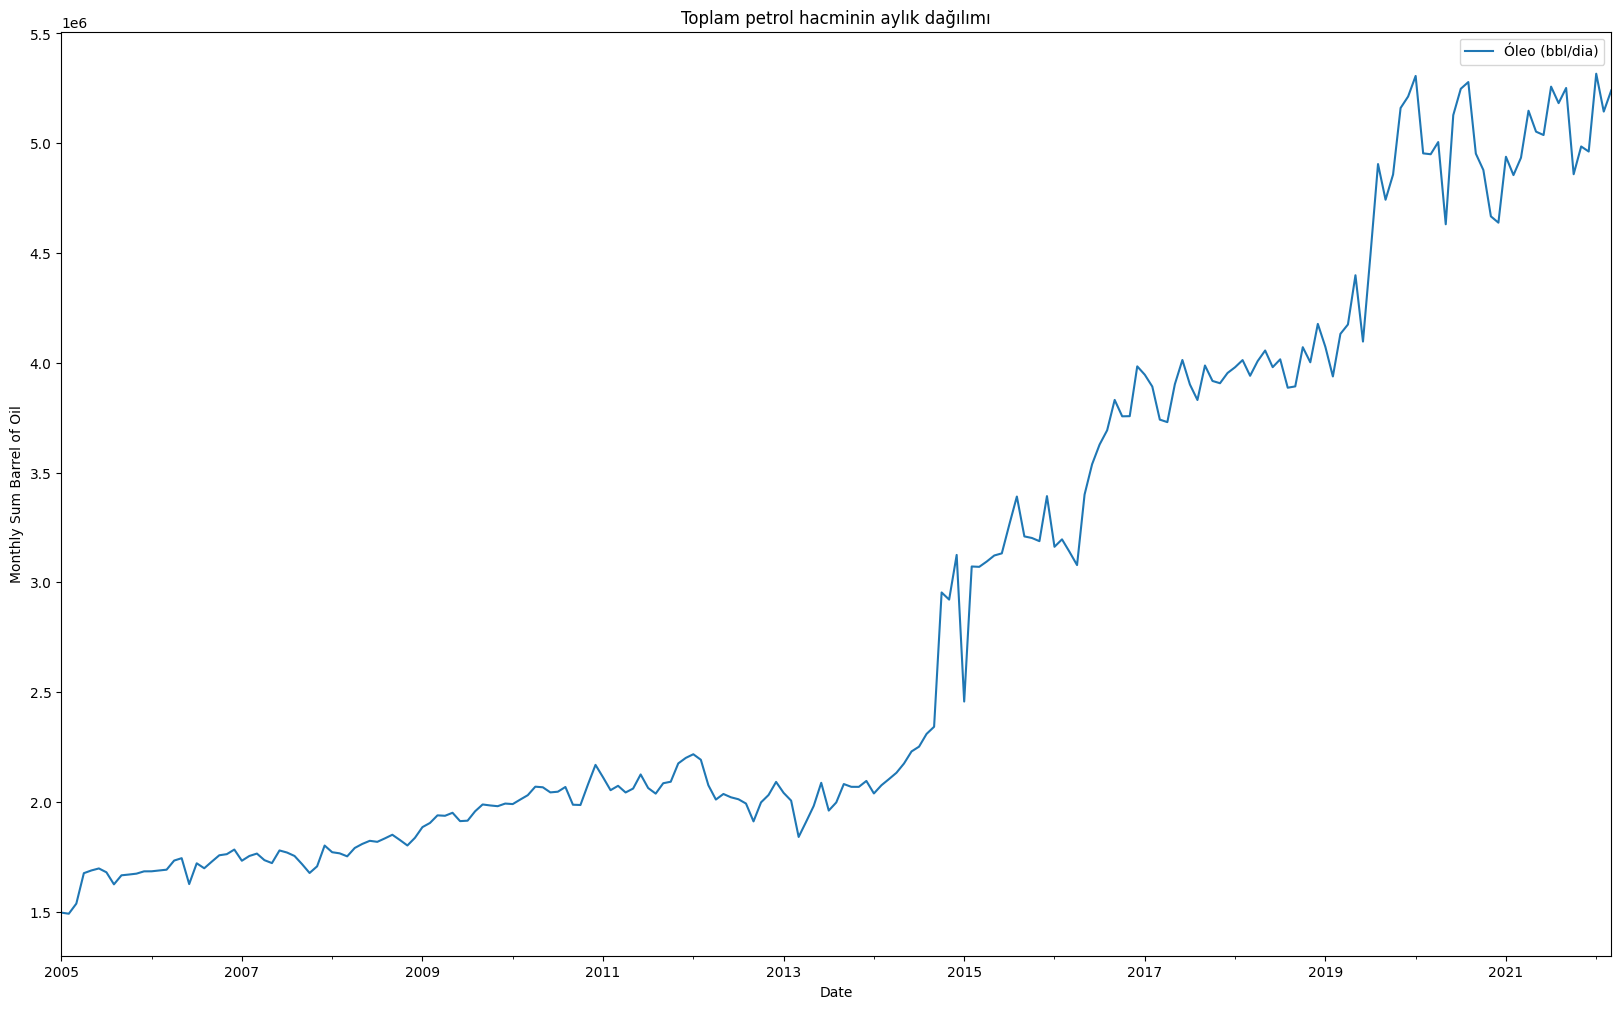

In [48]:
# Summarize and visualize monthly oil production from the dataset.

df=df1
df = pd.DataFrame(df.groupby(['Período']).sum()['Óleo (bbl/dia)'])
df['Date']=df.index
df.index=np.arange(0,len(df),1)

ax = pd.DataFrame(df['Óleo (bbl/dia)']).set_index(df['Date']).plot(figsize=(20, 12))
ax.set_ylabel('Monthly Sum Barrel of Oil')
ax.set_xlabel('Date')
plt.title('Toplam petrol hacminin aylık dağılımı')
plt.show()

In [49]:
# Based on the distribution of the data on the graph, we take the data after the date 2013-01-01 for analysis due to a breakpoint.
# Moreover, data from older dates can increase errors in time series prediction.

df = df[df['Date'] > '2013-01-01']
df.index = np.arange(0,len(df),1)
df.rename(columns={'Óleo (bbl/dia)':'y'}, inplace=True)

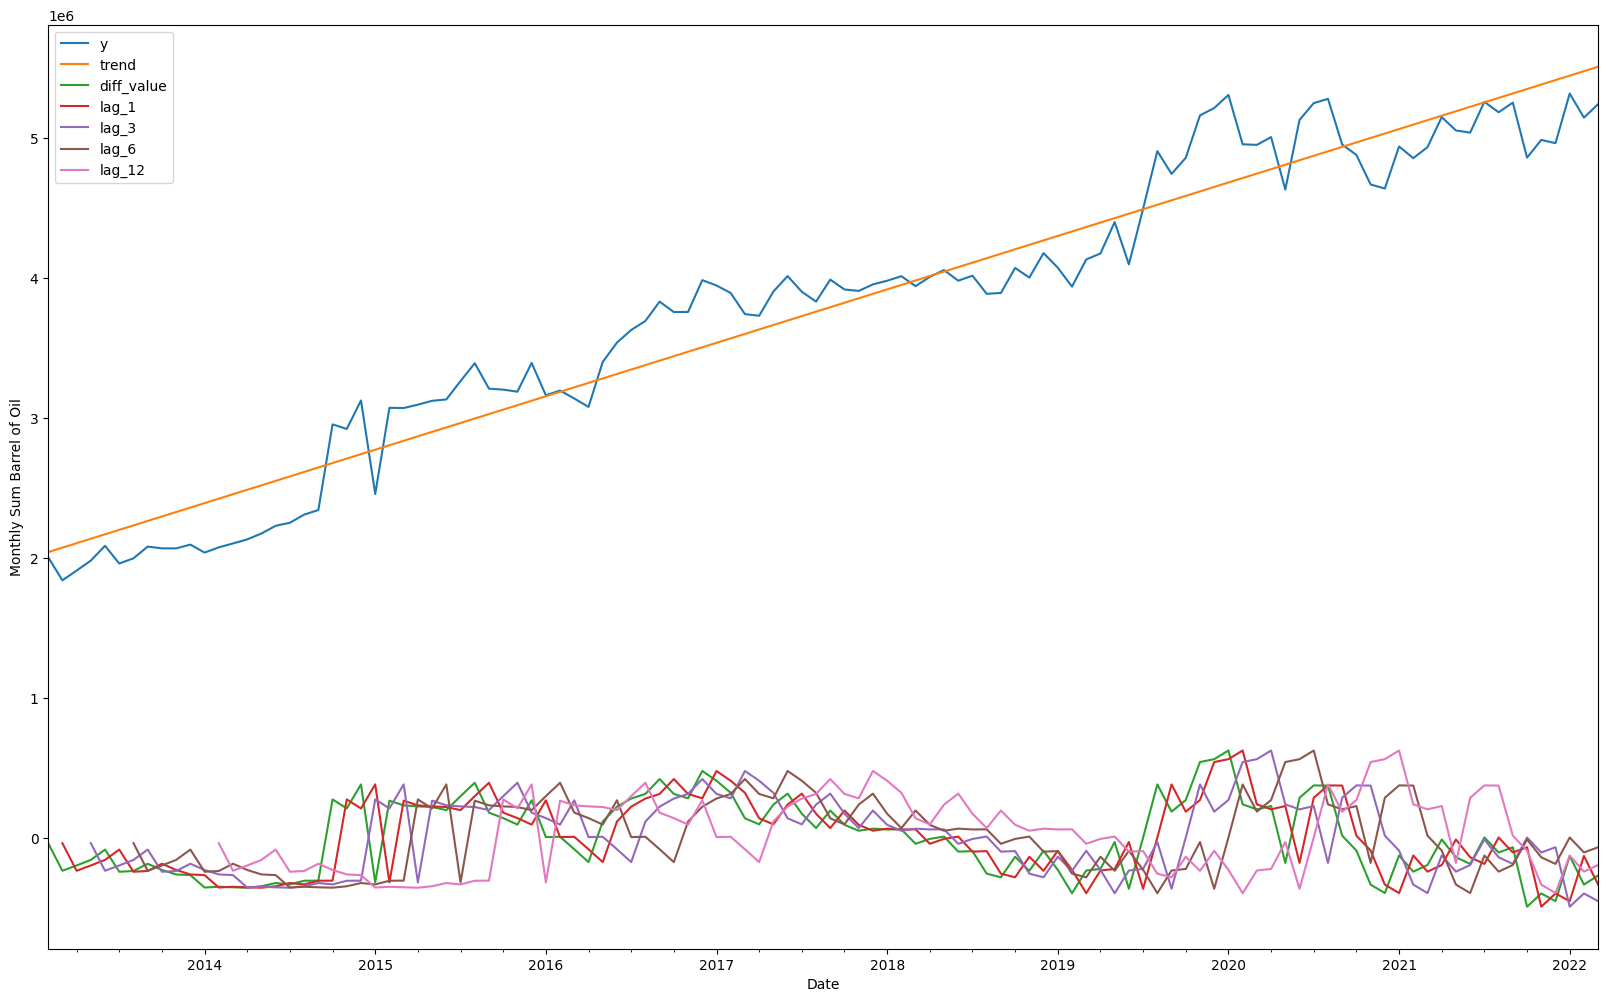

In [50]:
# Derive certain variables, fit a linear trend, compute differences, add lags, and visualize.

y = np.array(pd.DataFrame(df.y)).reshape(-1,1)
x = np.array(pd.DataFrame(df.index.values)).reshape(-1,1)
ln_reg = LinearRegression().fit(x, y)
trend = []

for i in df.index:
    trend_value = ln_reg.predict([[df.index[i]]])
    trend.append(trend_value)

df['trend']=np.array(trend).reshape(len(trend),1)
df['diff_value'] = df['y'] - df['trend']
for r in [1,3,6,12]:
    df['lag_'+str(r)] = df['diff_value'].shift(r)

ax = df.set_index('Date').plot(figsize=(20, 12))
ax.set_ylabel('Monthly Sum Barrel of Oil')
ax.set_xlabel('Date')

plt.show()


In [51]:
# Construct a model to forecast monthly values, iterating and using each prediction for the subsequent month's estimation.


month_pred = 12

for j in np.ones(month_pred):
    y = np.array(pd.DataFrame(df.y)).reshape(-1,1)
    x = np.array(pd.DataFrame(df.index.values)).reshape(-1,1)
    ln_reg = LinearRegression().fit(x, y)
    trend = []

    for i in df.index:
        trend_value = ln_reg.predict([[df.index[i]]])
        trend.append(trend_value)
    df['trend']=np.array(trend).reshape(len(trend),1)

    df['diff_value'] = df['y'] - df['trend']
    for r in [1,3,6,12]:
        df['lag_'+str(r)] = df['diff_value'].shift(r)
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    means = df.groupby('month').agg({'diff_value': 'mean'}).to_dict()['diff_value']
    df['monthavg'] = df['month'].map( means )
    df = pd.get_dummies(df, columns = ['year'])
    df.drop(columns=['trend','diff_value'],inplace=True)
    df['month'] = df['month'].astype(str).astype(int)

    df2 = df.loc[12:]
    df2.index = np.arange(0,len(df2),1)

    # define x and y

    y = df2['y']
    x = df2.drop(columns=['y','Date'])
    ln_reg = LinearRegression().fit(x,y)

    predicted_next = ln_reg.predict(np.array(x.tail(1)).reshape(1,-1))
    predicted_next
    new_date = pd.concat([df['Date'], pd.Series(df['Date'].tail(1).iloc[0] + pd.DateOffset(months=int(j)))]).reset_index(drop=True)
    new_y = pd.concat([df['y'], pd.Series(predicted_next[0])], ignore_index=True)
    df = pd.concat([new_date, new_y], axis=1)
    df.columns = ['Date', 'y']

print('Coefficients:', ln_reg.coef_)
print('İntercept:', round(ln_reg.intercept_,3))
print('Regr.Score:',round(ln_reg.score( x, y ),3))
print(df.tail(month_pred))

Coefficients: [ 5.89294031e-01  1.06767660e-01  7.52698955e-02 -4.69013393e-02
  3.18076733e+04  8.10534145e-01 -1.74622983e-09 -1.64953223e+06
 -1.26381963e+06 -8.55835655e+05 -5.41362966e+05 -2.19969511e+05
  2.61247799e+05  5.09221047e+05  8.75219651e+05  1.24318144e+06
  1.64165005e+06]
İntercept: 4047737.97
Regr.Score: 0.971
          Date       y
110 2022-04-01 5215945
111 2022-05-01 5275265
112 2022-06-01 5279612
113 2022-07-01 5336619
114 2022-08-01 5386021
115 2022-09-01 5434163
116 2022-10-01 5449194
117 2022-11-01 5506969
118 2022-12-01 5518677
119 2023-01-01 5603735
120 2023-02-01 5603735
121 2023-03-01 5625311


"""
This section of the project constructs a model to forecast monthly values by leveraging iterative predictions. At each iteration, the model's prediction for a given month is incorporated and then used in the estimation of the subsequent month's value. 

The Linear Regression model captures a trend component, utilizes lag values to consider past data, and also factors in the average monthly variations. For each iteration, it predicts the next month's oil production value based on the previous trend and the average variations of prior months.

The results showcase the coefficients for various features used in the prediction and indicate that the regression model has a high R^2 score of 0.971. This suggests the model explains approximately 97.1% of the variance in the dependent variable, signifying strong predictive power. The last 12 months of predictions are displayed, providing a forecast from April 2022 to March 2023.
"""


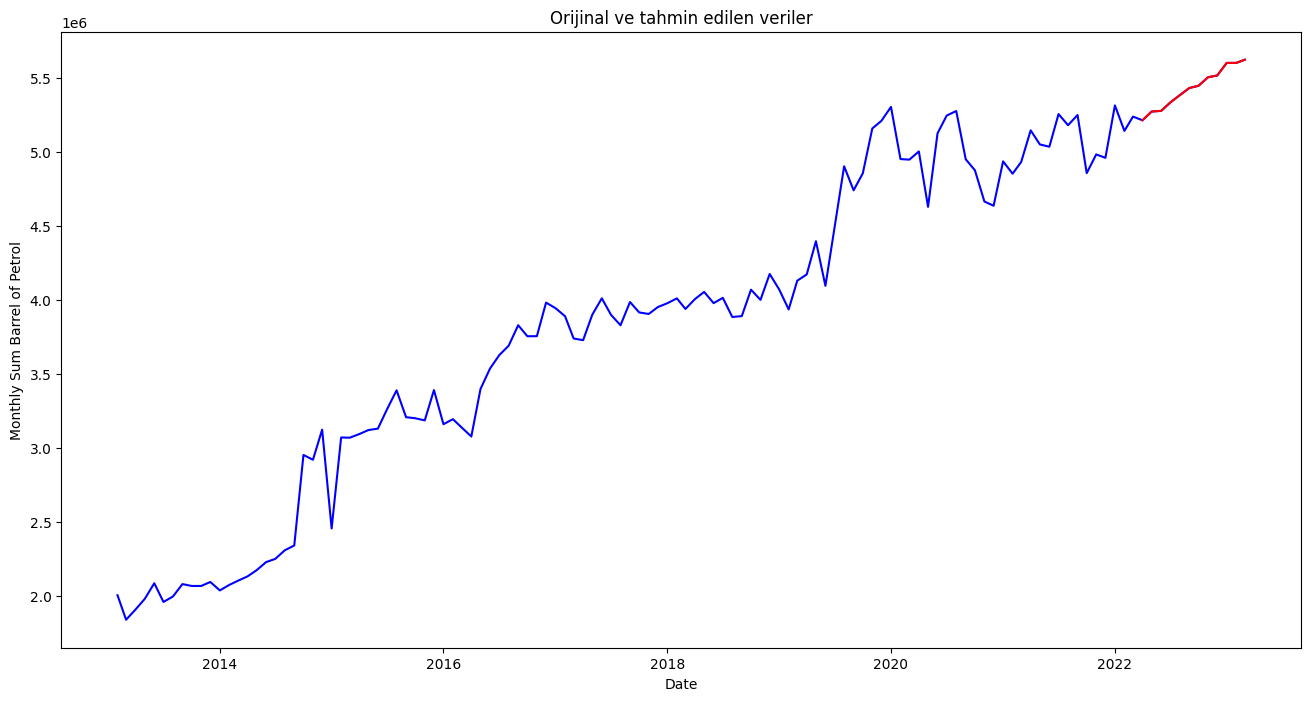

In [52]:
# Display the original values alongside the Linear Regression predicted values on a graph.

predict_values = df[df['Date']>'2022-03-01']
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df.set_index('Date'), color='b')
ax.plot(predict_values.set_index('Date'), color='r')
ax.set_ylabel('Monthly Sum Barrel of Petrol')
ax.set_xlabel('Date')
plt.title('Orijinal ve tahmin edilen veriler')
pl1 = plt.show()
pl1

### Time Series Fastapi (Linear Regression model)

In [54]:
# Deploy the trained Linear Regression model via FastAPI for monthly oil prediction in Brazil.

filename = 'regres_ts_model.sav'
pickle.dump(ln_reg, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x,y)

def dataset(pclass):
    observation = {"pred_month": [month_pred]}

    dataframe = pd.DataFrame(data = observation)
    
    return dataframe

app = FastAPI()

pickle_model = open("regres_ts_model.sav", "rb")
model = pickle.load(pickle_model)

@app.post('/Predict Brasil Oil')
def predict_oil_volume(month_pred: int,):
    """   Brasil monthly oil prediction. 
    Date - monthly date
    y -monthly oil  
"""
    user_data = dataset(month_pred)
    
    
    prediction = model.predict(x)
    
    return { str(df.tail(month_pred)[['Date','y']])}

import nest_asyncio
nest_asyncio.apply()

if __name__ == '__main__':
    uvicorn.run(app, host = '127.0.0.1', port = 8000)

# http://127.0.0.1:8000/docs

INFO:     Started server process [6696]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:51679 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:51679 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:51679 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:51678 - "POST /Predict%20Brasil%20Oil?month_pred=3 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [6696]


##### The FastAPI application successfully started and ran on http://127.0.0.1:8000. While running, it responded to various HTTP requests, including serving the built-in Swagger UI documentation at /docs and processing a POST request to the /Predict Brasil Oil endpoint with a 200 OK response. All operations concluded normally when the server was instructed to shut down. 

## Time Series With Prophet Library

In [55]:
# Use the Prophet library to forecast the next 24 months based on historical oil production data.

df=df1
df = pd.DataFrame(df.groupby(['Período']).sum()['Petróleo (bbl/dia)'])
df['Date']=df.index
df.index=np.arange(0,len(df),1)
df = df[df['Date'] > '2013-01-01']

df.index = np.arange(0,len(df),1)
df = df.rename(columns={'Petróleo (bbl/dia)': 'y',
                        'Date': 'ds'})

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='MS')
forecast = m.predict(future)
forecast

20:06:34 - cmdstanpy - INFO - Chain [1] start processing
20:06:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-02-01,1797956,1510235,2100520,1797956,1797956,19122,19122,19122,19122,19122,19122,0,0,0,1817078
1,2013-03-01,1836713,1529361,2076696,1836713,1836713,-37549,-37549,-37549,-37549,-37549,-37549,0,0,0,1799164
2,2013-04-01,1879623,1551588,2152650,1879623,1879623,-32265,-32265,-32265,-32265,-32265,-32265,0,0,0,1847357
3,2013-05-01,1921148,1594649,2148698,1921148,1921148,-31424,-31424,-31424,-31424,-31424,-31424,0,0,0,1889724
4,2013-06-01,1964058,1706950,2258523,1964058,1964058,29620,29620,29620,29620,29620,29620,0,0,0,1993677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2023-11-01,5783356,5547297,6114219,5757220,5814297,43539,43539,43539,43539,43539,43539,0,0,0,5826894
130,2023-12-01,5806961,5668360,6205388,5778828,5840118,127131,127131,127131,127131,127131,127131,0,0,0,5934093
131,2024-01-01,5831354,5523198,6088357,5800781,5866909,-28191,-28191,-28191,-28191,-28191,-28191,0,0,0,5803163
132,2024-02-01,5855747,5520783,6085725,5822571,5893436,-41919,-41919,-41919,-41919,-41919,-41919,0,0,0,5813828


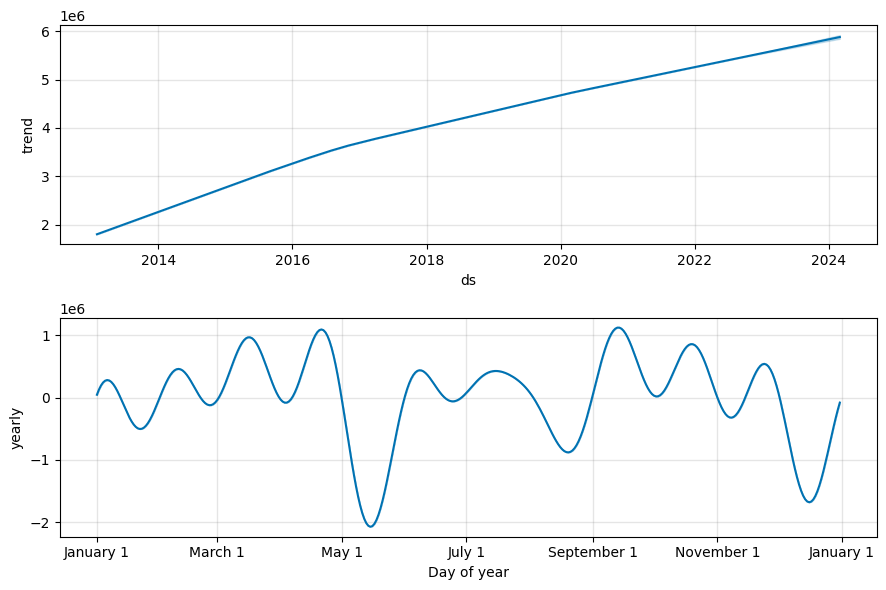

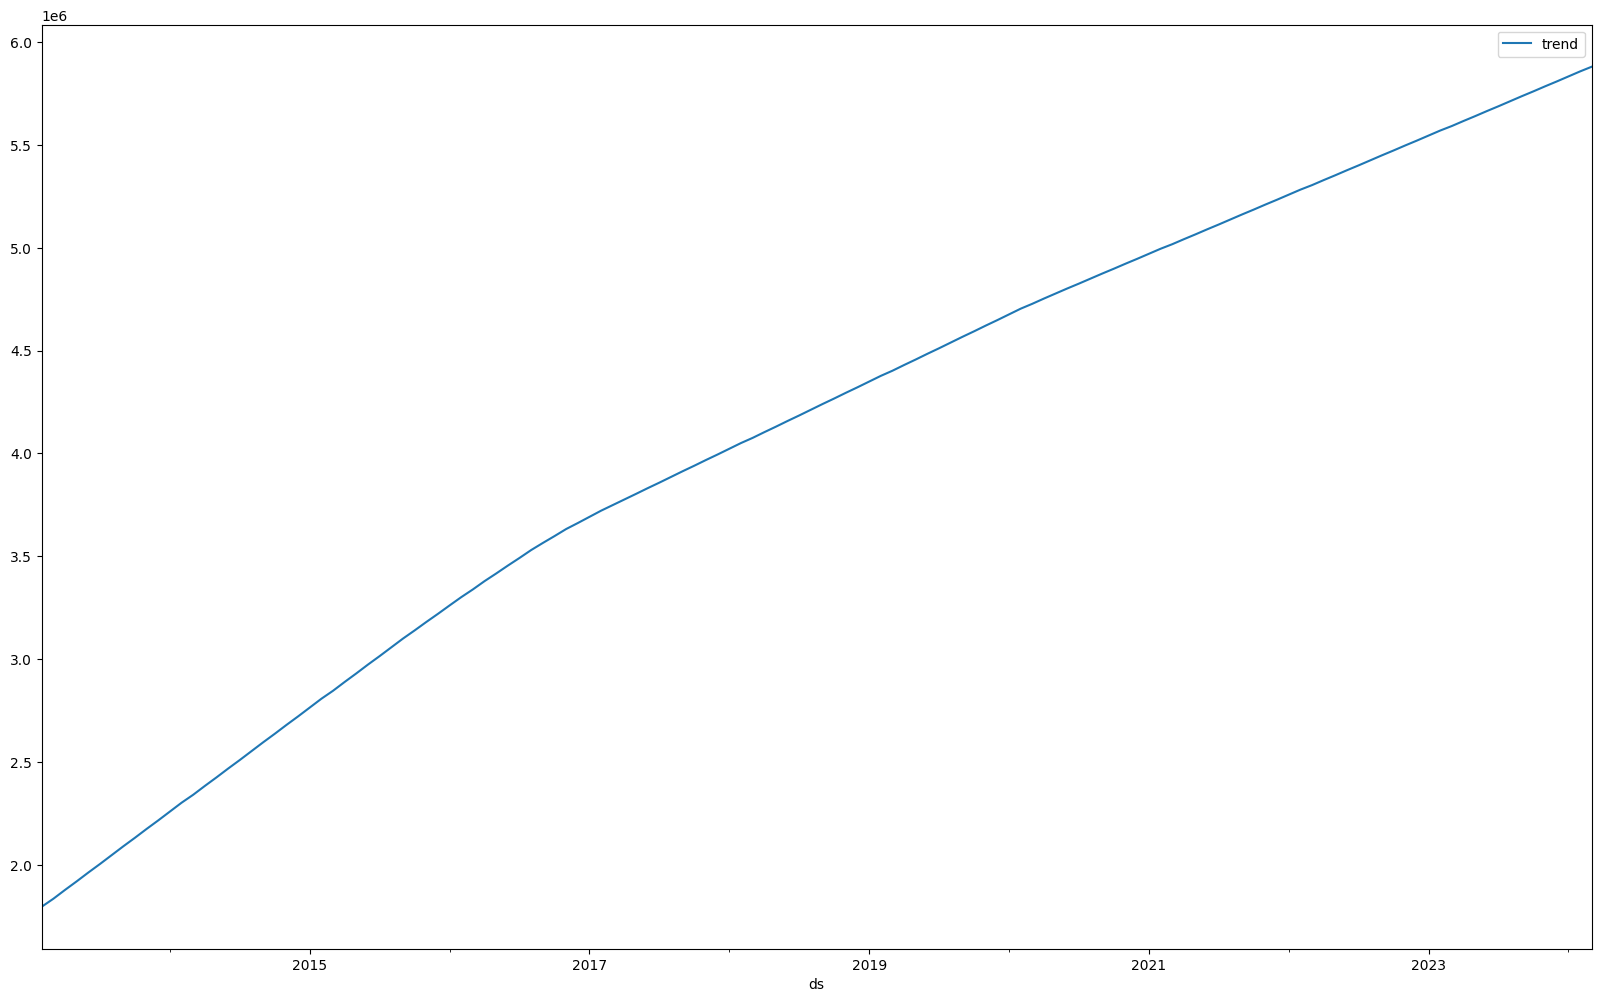

In [56]:
# Visualize the components of the Prophet forecast and the trend over time.

fig2 = m.plot_components(forecast)
ax = pd.DataFrame(forecast['trend']).set_index(forecast['ds']).plot(figsize=(20, 12))

In [57]:
# Prepare the predicted values for graphical representation, filtering specific date ranges.

ds = forecast['ds']
yhat = forecast['yhat']
forecastnew = pd.concat([ds,yhat], axis=1)
mask = (forecastnew['ds'] > "2022-03-01") & (forecastnew['ds'] <= "2024-03-01")
predict_values = forecastnew.loc[mask]
mask = (forecastnew['ds'] >= "2013-02-01") & (forecastnew['ds'] <= "2022-03-01")
forecastnew = forecastnew.loc[mask]
values = pd.merge(df, pd.DataFrame(forecast['ds']), how = 'outer',  on = 'ds')

In [58]:
# Display the table of predicted months using Prophet, showcasing upper, lower boundaries, and forecasted values.

predicted_months = forecast[forecast['ds']>'2022-03-01'][['ds','yhat_upper','yhat_lower','yhat']]
predicted_months

,ds,yhat_upper,yhat_lower,yhat
110,2022-04-01,5555950,5031774,5306069
111,2022-05-01,5641801,5099389,5369680
112,2022-06-01,5676964,5099991,5376275
113,2022-07-01,5735090,5185996,5464321
114,2022-08-01,5814867,5225023,5516879
115,2022-09-01,5738692,5196926,5462865
116,2022-10-01,5804697,5234490,5505583
117,2022-11-01,5791490,5223452,5517501
118,2022-12-01,5898350,5331806,5616085
119,2023-01-01,5835809,5274599,5541173


Yellow = Upper_yhat Green = Lower_yhat Black = Original values Red = Predicted Values, Blue = Base Values(Yhat)


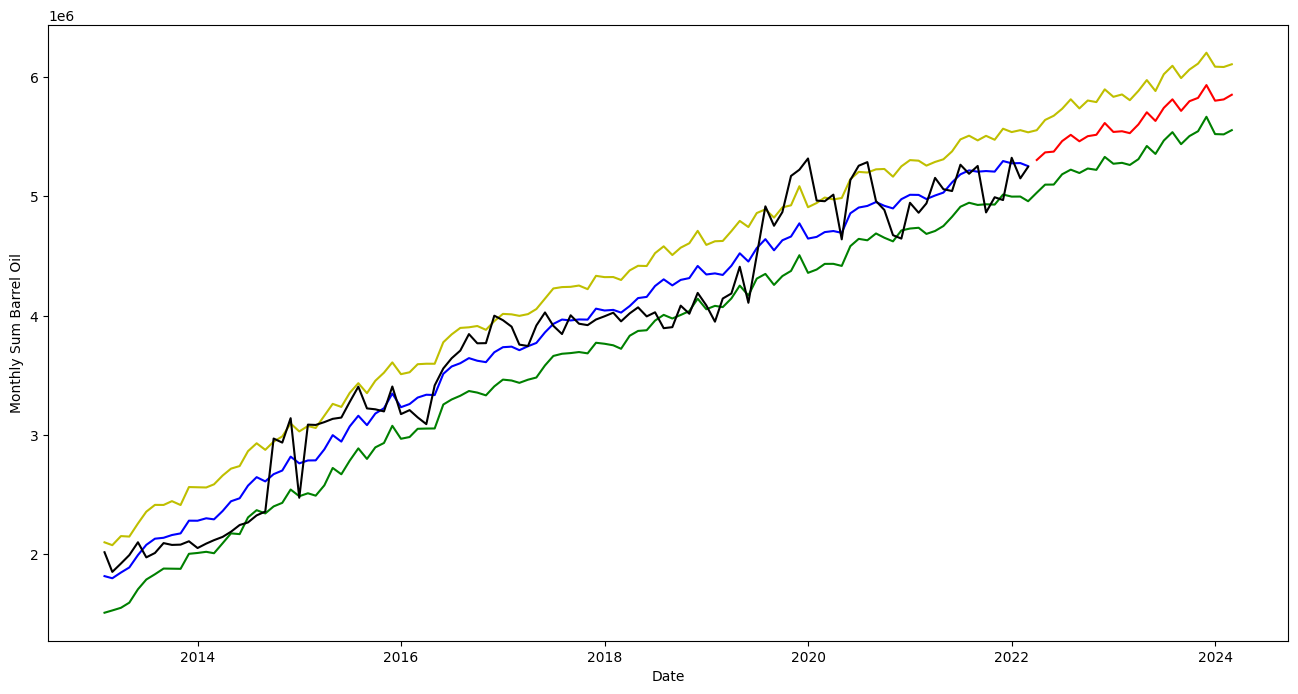

In [59]:
# Plot the original, predicted, and confidence interval values from the Prophet library on a graph.

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(forecastnew.set_index('ds'), color='b')
ax1.plot(pd.DataFrame(forecast['yhat_lower']).set_index(forecast['ds']), color='g')
ax1.plot(pd.DataFrame(forecast['yhat_upper']).set_index(forecast['ds']), color='y')
ax1.plot(values.set_index('ds'), color='k')
ax1.plot(predict_values.set_index('ds'), color='r')
ax1.set_ylabel('Monthly Sum Barrel Oil')
ax1.set_xlabel('Date')
print('Yellow = Upper_yhat','Green = Lower_yhat', 'Black = Original values', "Red = Predicted Values, Blue = Base Values(Yhat)")

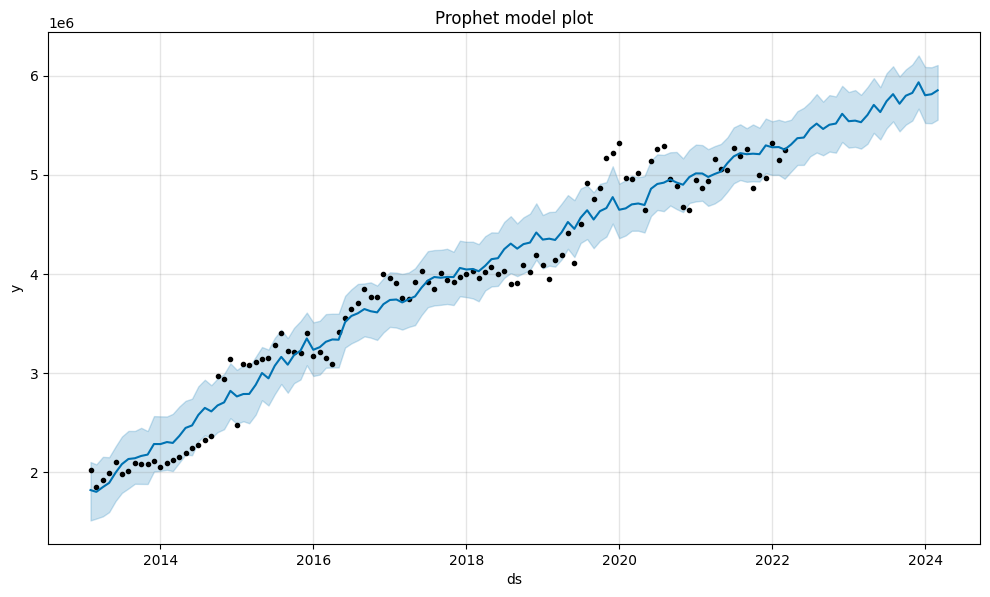

In [60]:
# Display the built-in Prophet model plot for the forecasted values.

m.plot(forecast)
plt.title('Prophet model plot')
pl2 = plt.show()
pl2

In [61]:
# Calculate and display evaluation metrics for the Prophet model's predictions.

print('mean_squared_error:', round(mean_squared_error(df.y,forecast.head(110)['yhat']),3))
print('mean_absolute_error', round(mean_absolute_error(df.y,forecast.head(110)['yhat']),3))
print('mean_absolute_percentage_error', round(mean_absolute_percentage_error(df.y,forecast.head(110)['yhat']),3))
print('r2_score', round(r2_score(df.y,forecast.head(110)['yhat']),3))

mean_squared_error: 46628877500.297
mean_absolute_error 177184.73
mean_absolute_percentage_error 0.05
r2_score 0.957


"""
This section of the project calculates and displays the evaluation metrics for the predictions made using the Prophet model. Metrics like mean squared error, mean absolute error, mean absolute percentage error, and R^2 score provide insights into the model's accuracy and performance.

The results indicate the model has a high R^2 score of 0.957, suggesting it accounts for approximately 95.7% of the variance in the dependent variable. The other metrics, including the mean absolute error and mean squared error, give context to the magnitude and direction of the prediction errors.
"""
